In [23]:
from os import listdir
import pandas as pd
import numpy as np
import seaborn as sns # For graphs and visualization.
import entropy
# Machine learning tools From scikit-learn library.
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
# Classifiers used
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [24]:
# Calculates different entropy values for a binary executable and creates a feature list.
def get_feature_list(content):
	v0 = entropy.shannon_entropy(content)
	v1 = sum(entropy.sample_entropy(content, 3))
	v2 = entropy.permutation_entropy(content)
	#v3 = entropy.weighted_permutation_entropy(content)
	#v4 = sum(entropy.multiscale_entropy(content, 3, maxscale=3))
	return [v0, v1, v2] # , v3, v4

In [25]:
# Create dataset by calculating entropy values for each file under './Packed' and './Not Packed' directories.
if "collection.csv" not in listdir():
	HEADERS = ["Shannon Entropy", "Sample Entropy", "Permutation Entropy", "Target"] # , "Weighted Permutation Entropy", "Multiscale Entropy"
	entries = []

	for category, class_val in zip(["Not Packed", "Packed"], [0, 1]):
		for file in listdir(f"./{category}/"):
			print(f"Calculating values for './{category}/{file}'")
			with open(f"./{category}/{file}", "rb") as f:
				content = list(f.readline()) 
				entries.append(get_feature_list(content)+[class_val])
				
	data_frame = pd.DataFrame(entries, columns=HEADERS)
	data_frame.to_csv("collection.csv", sep=",", header=True)

In [26]:
# Load the dataframe.
data_frame = pd.read_csv("collection.csv",  sep=",")
data_frame = data_frame.iloc[: , 1:] # Dropping the Index column as it confuses the learning algorithms.

In [27]:
data_frame.head() # First 5 entries from the dataframe.

,Shannon Entropy,Sample Entropy,Permutation Entropy,Target
0,1.014186,0.254144,0.638124,0
1,3.780757,1.912172,1.937650,0
2,2.745957,1.138383,1.749375,0
3,3.905925,2.085990,2.187287,0
4,3.780757,1.912172,1.937650,0


In [28]:
data_frame.describe() # We can see max values each feature got using this method, and many more quick glance data.

,Shannon Entropy,Sample Entropy,Permutation Entropy,Target
count,499.000000,499.000000,499.000000,499.000000
mean,3.491992,1.732392,1.876595,0.498998
std,0.958109,0.617701,0.375710,0.500501
min,0.028323,0.007573,0.028064,0.000000
25%,3.718264,1.775312,1.937650,0.000000
50%,3.780757,1.912172,1.937650,0.000000
75%,3.780757,1.912172,1.937650,1.000000
max,6.689174,6.064947,2.575638,1.000000


In [29]:
# For example there are 500 rows we can also see that via
print(f"This data frame has [{len(data_frame)}] entries. ")

This data frame has [499] entries. 


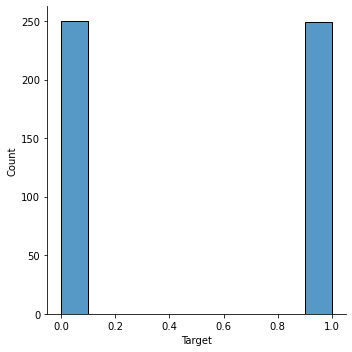

In [30]:
sns.displot(data_frame["Target"])
# Distrubtion of class variables. 250 unpacked and 250 packed entry

In [9]:
print(data_frame.info()) 
# This shows datatypes for each column in the dataframe and how many of those attributes are NonNull value.
# For example some classifiers cannot work with Null or Infinite values so we will have to get rid of them.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Shannon Entropy      499 non-null    float64
 1   Sample Entropy       499 non-null    float64
 2   Permutation Entropy  499 non-null    float64
 3   Target               499 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 15.7 KB
None


In [10]:
# We need to remove any rows that contain NaN or Infinite Values from the table
data_frame = data_frame.replace([np.inf, -np.inf], np.nan) # Replacing inf values with NaN.
data_frame = data_frame.dropna(axis="index") # Dropping all entries that contain NaN value.
# Right now this table doesn't have any so we can omit this block of code.

In [11]:
# Earlier when we checked .describe method we saw that max value for a cell under "Shannon Entropy" column was 6.689174
data_frame[data_frame["Shannon Entropy"] > 6] # For example we can look for entries that have Shannon Entropy above 6.
# When entropy is higher, it means randomness is higher. If entropy values are high it is very likely that, 
# that file is packed. We can see all entries that have Shannon Entropy value above 6 are indeed, packed.

,Shannon Entropy,Sample Entropy,Permutation Entropy,Target
323,6.610179,3.892510,2.527736,1
352,6.689174,3.865975,2.513459,1
367,6.484307,3.544386,2.497058,1
371,6.256508,3.235349,2.447575,1
427,6.032683,3.319963,2.512077,1
465,6.187923,3.412886,2.491258,1
482,6.244201,3.349199,2.492873,1


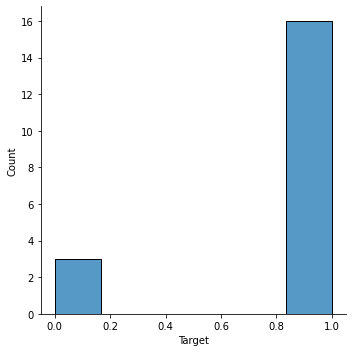

In [12]:
sns.displot(data_frame[data_frame["Shannon Entropy"] > 5]["Target"])

<AxesSubplot:xlabel='Target', ylabel='Permutation Entropy'>

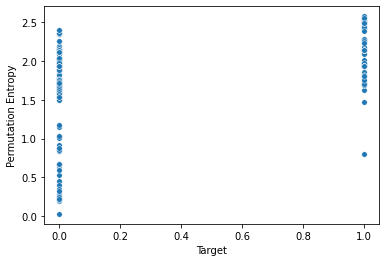

In [13]:
# We can also view relation between a feature and target column like this.
sns.scatterplot(x=data_frame["Target"], y=data_frame["Permutation Entropy"], s=30)
# In this graph we see that if a file is packed it's very likely that its "Permutation Entropy" value is 
# greater or equal to 1.5 as can be seen on the graph. Or in another words, if a file has Permutation Entropy value 
# lower than 1.5 we can assume that file is a "Non Packed" file.

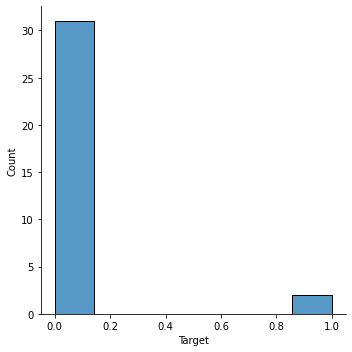

In [14]:
sns.displot(data_frame[data_frame["Permutation Entropy"] < 1.5]["Target"])

<AxesSubplot:xlabel='Shannon Entropy', ylabel='Permutation Entropy'>

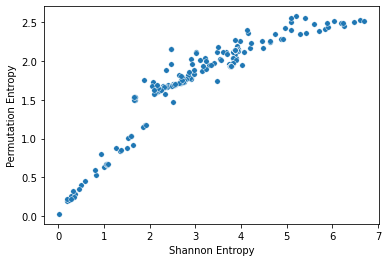

In [15]:
# We can also view relation between two input features like this.
sns.scatterplot(x=data_frame["Shannon Entropy"], y=data_frame["Permutation Entropy"], s=30)
# In this graph we see that there is positive correlation between "Shannon Entropy" and "Permutation Entropy"

In [16]:
target_vals = data_frame["Target"]				# Only target column for every entry : y
entries = data_frame.drop(["Target"], axis=1)	# Every column except the target column for every entry : x
x_train, x_test, y_train, y_test = train_test_split(entries, target_vals, test_size=0.25, random_state=105) # Dividing the data into training and test sets with 75/25 ratio

In [17]:
# Dictionary containing all the classifier methods that will be used to train our dataset.
# This dictionary is iterated and its inside will be filled with relative data and will contain the trained model for later use if needed.
classifiers = {
	"GaussianNB" : {
		"Constructor" : GaussianNB 
	},
	"MultinomialNB" : {
		"Constructor" : MultinomialNB 
	},
	"KNeighborsClassifier" : {
		"Constructor" : KNeighborsClassifier 
	},
	"RandomForestClassifier" : {
		"Constructor" : RandomForestClassifier 
	},
	"GradientBoostingClassifier" : {
		"Constructor" : GradientBoostingClassifier 
	},
	"LinearDiscriminantAnalysis" : { 
		"Constructor" : LinearDiscriminantAnalysis
	},
	"SGDClassifier" : {
		"Constructor" : SGDClassifier
	},
	"DecisionTreeClassifier" : {
		"Constructor" : DecisionTreeClassifier
	} 
}

In [21]:
most_accurate_classifier = ["classifier", 0]
# For each classifier in classifiers dictionary, train the classifier, store the trained model as well as the calculated data about the trained model.
for classifier in classifiers:
	classifier_object = classifiers[classifier]["Constructor"]()
	classifier_object.fit(x_train, y_train)
	classifiers[classifier]["Model"] = classifier_object
	prediction = classifier_object.predict(x_test)
	classifiers[classifier]["Confusion_Matrix"] = confusion_matrix(prediction, y_test) # Left diagonal values are the correct guesses and other values are mispredictions.
	classifiers[classifier]["Accuracy"] = accuracy_score(prediction, y_test) # Compares what model guessed and what it actually is to get the accuracy.
	classifiers[classifier]["Cross_Validation_Score"] = cross_val_score(classifier_object, x_test, y_test, cv=10).mean()
	if most_accurate_classifier[1] <  classifiers[classifier]["Cross_Validation_Score"]:
		most_accurate_classifier = classifier, classifiers[classifier]["Cross_Validation_Score"]
	print("Classifier: {classifier} --> Accuracy: {accuracy:.4f}, Cross Validation Score: {cvs:.4f}".format(classifier=classifier, accuracy=classifiers[classifier]["Accuracy"], cvs=classifiers[classifier]["Cross_Validation_Score"]))

Classifier: GaussianNB --> Accuracy: 0.6400, Cross Validation Score: 0.6455
Classifier: MultinomialNB --> Accuracy: 0.5280, Cross Validation Score: 0.6801
Classifier: KNeighborsClassifier --> Accuracy: 0.6560, Cross Validation Score: 0.7423
Classifier: RandomForestClassifier --> Accuracy: 0.7440, Cross Validation Score: 0.7590
Classifier: GradientBoostingClassifier --> Accuracy: 0.7280, Cross Validation Score: 0.7423
Classifier: LinearDiscriminantAnalysis --> Accuracy: 0.7120, Cross Validation Score: 0.7359
Classifier: SGDClassifier --> Accuracy: 0.5360, Cross Validation Score: 0.6686
Classifier: DecisionTreeClassifier --> Accuracy: 0.7360, Cross Validation Score: 0.7090


In [22]:
print(f"The most accurate classifier is: '{most_accurate_classifier[0]}' with highest percentage of cross_val_score: {round(most_accurate_classifier[1]*100, 3)}%")

The most accurate classifier is: 'RandomForestClassifier' with highest percentage of cross_val_score: 75.897%
